# Where is Waldo?

In [72]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread
import pandas as pd
import numpy as np
from PIL import Image
import os
import random

import torch.nn.functional as F
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, Dataset, DataLoader, ConcatDataset
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import WeightedRandomSampler


from tqdm import tqdm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")   # use GPU if available
print(device)

cuda


## Data Loading

In [3]:
!apt-get install git

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git is already the newest version (1:2.34.1-1ubuntu1.10).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


In [4]:
!git clone https://github.com/vc1492a/Hey-Waldo.git

Cloning into 'Hey-Waldo'...
remote: Enumerating objects: 18822, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 18822 (delta 6), reused 11 (delta 4), pack-reused 18808
Receiving objects: 100% (18822/18822), 112.66 MiB | 33.97 MiB/s, done.
Resolving deltas: 100% (38/38), done.
Updating files: 100% (20840/20840), done.


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [78]:
# Custom Dataset "WaldoDataset"
class WaldoDataset(Dataset):
    def __init__(self, directories, transform=None):
        self.filenames = []
        self.labels = []
        self.transform = transform

        # Loop through the directories
        for directory, label, reshape_size in directories:
            for fname in os.listdir(directory):
                if fname.lower().endswith('.jpg'):
                    full_path = os.path.join(directory, fname)
                    self.filenames.append(full_path)
                    self.labels.append(label)
                    self.reshape_size = reshape_size

    # Get length
    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        # Load an image
        img = Image.open(self.filenames[idx])

        # Resize if reshape_size is specified
        if self.reshape_size:
            img = img.resize(self.reshape_size)

        # Apply the transformation to tensor
        if self.transform:
            img = self.transform(img)

        # Get label
        label = self.labels[idx]

        return img, label

# Transformation to tensor
tensor_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Directories which contain
directories = [
    # Reshape all images to 128x128
    ("/content/Hey-Waldo/64/waldo", 1, (128, 128)),
    ("/content/Hey-Waldo/64/notwaldo", 0, (128, 128)),
    ("/content/Hey-Waldo/128/waldo", 1, None),
    ("/content/Hey-Waldo/128/notwaldo", 0, None)
]

# Create the dataset
waldo_dataset = WaldoDataset(directories, tensor_transform)

# Calculate split sizes
total_size = len(waldo_dataset)
test_size = int(0.1 * total_size)
train_eval_size = total_size - test_size
train_size = int(0.9 * train_eval_size)
val_size = train_eval_size - train_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(waldo_dataset, [train_size, val_size, test_size])

# Count labels in each subset
def count_labels_in_subset(dataset, subset):
    label_0_count = 0
    label_1_count = 0

    for idx in subset.indices:
        label = dataset.labels[idx]
        if label == 0:
            label_0_count += 1
        elif label == 1:
            label_1_count += 1

    return label_0_count, label_1_count

label_0_train_size, label_1_train_size = count_labels_in_subset(waldo_dataset, train_dataset)
label_0_val_size, label_1_val_size = count_labels_in_subset(waldo_dataset, val_dataset)
label_0_test_size, label_1_test_size = count_labels_in_subset(waldo_dataset, test_dataset)

# Print dataset statistics
print(f"Length of whole dataset: {len(waldo_dataset)}")
print("----------------------------------------------------------")
print(f"Length of the training set: {len(train_dataset)}")
print(f"Number of label 0 in the training set: {label_0_train_size}")
print(f"Number of label 1 in the training set: {label_1_train_size}")
print("----------------------------------------------------------")
print(f"Length of the validation set: {len(val_dataset)}")
print(f"Number of label 0 in the validation set: {label_0_val_size}")
print(f"Number of label 1 in the validation set: {label_1_val_size}")
print("----------------------------------------------------------")
print(f"Length of the test set: {len(test_dataset)}")
print(f"Number of label 0 in the test set: {label_0_test_size}")
print(f"Number of label 1 in the test set: {label_1_test_size}")

Length of whole dataset: 6720
----------------------------------------------------------
Length of the training set: 5443
Number of label 0 in the training set: 5388
Number of label 1 in the training set: 55
----------------------------------------------------------
Length of the validation set: 605
Number of label 0 in the validation set: 603
Number of label 1 in the validation set: 2
----------------------------------------------------------
Length of the test set: 672
Number of label 0 in the test set: 663
Number of label 1 in the test set: 9


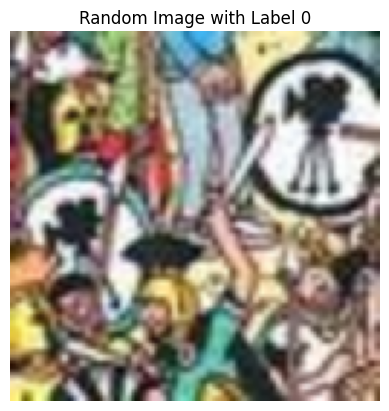

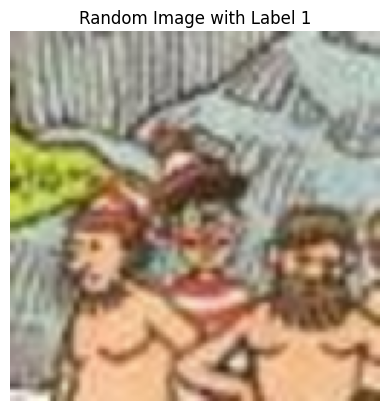

In [79]:
def show_random_image_from_each_label(dataset):
    # Get unique labels in the dataset (0 & 1)
    unique_labels = set(dataset.labels)
    # Iterate for each unique label
    for label in unique_labels:
        # Find indices for current label
        indices_for_label = [i for i, l in enumerate(dataset.labels) if l == label]

        # Choose a random index for the current label
        random_index = random.choice(indices_for_label)
        # Get the image and label
        image, _ = dataset[random_index]

        # Display the random chosen image with the label
        plt.figure()
        plt.imshow(image.permute(1, 2, 0))
        plt.title(f"Random Image with Label {label}")
        plt.axis('off')
        plt.show()

show_random_image_from_each_label(waldo_dataset)

## Data Processing

In [80]:
def compute_mean_std(dataset):
    sum_rgb = torch.zeros(3)
    sum_rgb_squared = torch.zeros(3)
    num_pixels = 0

    for img, _ in dataset:
        img = img.view(3, -1)  # Flatten the image to get the pixel values for each channel
        sum_rgb += img.sum(dim=1)  # Sum up all the pixel values for each RGB channel
        sum_rgb_squared += (img ** 2).sum(dim=1)  # Sum up the squares of all pixel values for each RGB channel
        num_pixels += img.shape[1]  # Count the total number of pixels processed

    mean = sum_rgb / num_pixels  # Compute the mean for each RGB channel
    std = (sum_rgb_squared / num_pixels - mean ** 2).sqrt()  # Compute the standard deviation for each RGB channel

    return mean, std

mean_train, std_train = compute_mean_std(train_dataset)
print("Mean of RGB channels:", mean_train)
print("Standard Deviation of RGB channels:", std_train)

Mean of RGB channels: tensor([0.6365, 0.5861, 0.4934])
Standard Deviation of RGB channels: tensor([0.2647, 0.2730, 0.2746])


In [81]:
class TransformedDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __getitem__(self, idx):
        data, target = self.dataset[idx]
        if self.transform:
            data = self.transform(data)  # Apply the transformation
        return data, target

    def __len__(self):
        return len(self.dataset)

In [82]:
class Patchify(nn.Module):
    def __init__(self, img_size=128, patch_size=16, embed_dim=768):
        super().__init__()
        self.num_patches = (img_size // patch_size) * (img_size // patch_size)
        self.proj = nn.Conv2d(3, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = self.proj(x)  # (B, E, P, P)
        x = x.flatten(2).transpose(1, 2)  # (B, N, E)
        return x

# Other classes (FeedForward, MultiHeadAttention, Transformer) remain unchanged
class FeedForward(nn.Module):
    def __init__(self, dim, dropout = 0.):
        super().__init__()

        self.net = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, dim * 4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(dim * 4, dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

class MultiHeadAttention(nn.Module):

    def __init__(self, dim, heads = 8, dropout = 0.):
        super().__init__()
        self.dim = dim
        self.heads = heads

        self.query = nn.Linear(dim, dim)
        self.keys = nn.Linear(dim, dim)
        self.values = nn.Linear(dim, dim)

        self.norm = nn.LayerNorm(dim)

        self.out_proj = nn.Linear(dim, dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # N is the total number of patches
        B, N, C = x.shape

        x = self.norm(x)         # (B, N, C)

        query = self.query(x)    # (B, N, C)
        key = self.keys(x)       # (B, N, C)
        value = self.values(x)   # (B, N, C)

        dim_head = C // self.heads

        # Split (B,N,C) into (B, N, num_heads, dim_head) and permute heads which yields a shape of (B, num_heads, N, dim_head)
        # each of the heads, should have (N, dim_head)
        query = query.reshape(B, N, self.heads, dim_head).permute(0,2,1,3)
        key = key.reshape(B, N, self.heads, dim_head).permute(0,2,1,3)
        value = value.reshape(B, N, self.heads, dim_head).permute(0,2,1,3)

        # (B, num_heads, N, dim_head) with (B, num_heads, N, dim_head) --> (B, num_heads, N, N)
        attention_scores = torch.matmul(query, key.transpose(-1, -2))

        scale = dim_head ** -0.5   # (1 / sqrt(dim_head))
        attention_scores = attention_scores * scale
        attention_scores = F.softmax(attention_scores, dim = -1) # (B, num_heads, N, N)
        attention_scores = self.dropout(attention_scores)

        # extract the values
        # (B, num_heads, N, N) matmul (B, num_heads, N, dim_head) --> (B, num_heads, N, dim_head)
        out = torch.matmul(attention_scores, value)

        # (B, num_heads, N, dim_head) --> (B, N, num_heads, dim_head) --> (B, N, C)
        out = out.permute(0,2,1,3).flatten(2)   # or we can use .reshape(B, N, -1) rather than .flatten(2)
        out = self.out_proj(out)
        return out


class Transformer(nn.Module):
    def __init__(self, dim, num_layers, heads, dropout = 0.):

        super().__init__()

        self.norm = nn.LayerNorm(dim)
        self.layers = nn.ModuleList([])

        for _ in range(num_layers):
            self.layers.append(nn.ModuleList([
                MultiHeadAttention(dim, heads = heads, dropout = dropout),
                FeedForward(dim, dropout = dropout)]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x

        return self.norm(x)

class ViT(nn.Module):
    def __init__(self, image_size=128, patch_size=16, num_classes=2, dim=768, num_layers=6, heads=12, dropout=0.1):
        super().__init__()
        self.patchify = Patchify(image_size, patch_size, dim)
        self.pos_encoding = nn.Parameter(torch.randn(1, self.patchify.num_patches + 1, dim))
        self.cls_token = nn.Parameter(torch.randn(1, 1, dim))
        self.transformer = Transformer(dim, num_layers, heads, dropout)
        self.classifier = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        B = x.shape[0]
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = self.patchify(x)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_encoding
        x = self.transformer(x)
        x = x[:, 0]  # Take the CLS token
        x = self.classifier(x)
        return x

# Model instantiation
model = ViT()

## Step 1: Triplet Loss

In [83]:
class TripletWaldoDataset(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
        self.labels = [label for _, label in subset]
        self.label_to_indices = {label: np.where(np.array(self.labels) == label)[0]
                                 for label in np.unique(self.labels)}

        # Precompute negative indices for efficiency
        self.label_to_negative_indices = {label: np.where(np.array(self.labels) != label)[0]
                                          for label in np.unique(self.labels)}

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        anchor_img, anchor_label = self.subset[idx]
        if self.transform:
            anchor_img = self.transform(anchor_img)

        positive_idx = idx
        while positive_idx == idx:
            positive_idx = np.random.choice(self.label_to_indices[anchor_label])

        negative_label = np.random.choice(list(self.label_to_negative_indices.keys()))
        negative_idx = np.random.choice(self.label_to_negative_indices[negative_label])

        positive_img, _ = self.subset[positive_idx]
        negative_img, _ = self.subset[negative_idx]

        if self.transform:
            positive_img = self.transform(positive_img)
            negative_img = self.transform(negative_img)

        return anchor_img, positive_img, negative_img, anchor_label

In [84]:
transform_dataset_step_1 = transforms.Compose([
    transforms.Normalize(mean_train, std_train),
])

train_dataset_step_1 = TransformedDataset(train_dataset, transform_dataset_step_1)
val_dataset_step_1 = TransformedDataset(val_dataset, transform_dataset_step_1)
test_dataset_step_1 = TransformedDataset(test_dataset, transform_dataset_step_1)

train_triplet_dataset = TripletWaldoDataset(train_dataset_step_1)
val_triplet_dataset = TripletWaldoDataset(val_dataset_step_1)
test_triplet_dataset = TripletWaldoDataset(test_dataset_step_1)

train_loader_step_1 = DataLoader(train_triplet_dataset, batch_size = 16,   shuffle=True)
val_loader_step_1 = DataLoader(val_triplet_dataset, batch_size = 16,  shuffle=False)
test_loader_step_1 = DataLoader(test_triplet_dataset, batch_size = 16,  shuffle=False)

In [86]:
# Define the triplet loss

class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        distance_positive = (anchor - positive).pow(2).sum(1).sqrt()  # Euclidean distance
        distance_negative = (anchor - negative).pow(2).sum(1).sqrt()
        losses = torch.relu(distance_positive - distance_negative + self.margin)
        return losses.mean()



def train_one_epoch(model, train_loader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    positive_distances = []
    negative_distances = []

    for batch_idx, (anchor, positive, negative, _) in enumerate(train_loader):
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

        optimizer.zero_grad()

        anchor_out = model(anchor)
        positive_out = model(positive)
        negative_out = model(negative)

        loss = loss_fn(anchor_out, positive_out, negative_out)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Calculate and store distances
        distance_positive = (anchor_out - positive_out).pow(2).sum(1).sqrt().mean().item()
        distance_negative = (anchor_out - negative_out).pow(2).sum(1).sqrt().mean().item()
        positive_distances.append(distance_positive)
        negative_distances.append(distance_negative)

    avg_loss = total_loss / len(train_loader)
    return avg_loss, positive_distances, negative_distances

def evaluate(model, val_loader, loss_fn, device):
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for batch_idx, (anchor, positive, negative, _) in enumerate(val_loader):
            anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

            anchor_out = model(anchor)
            positive_out = model(positive)
            negative_out = model(negative)

            loss = loss_fn(anchor_out, positive_out, negative_out)
            total_loss += loss.item()

    avg_loss = total_loss / len(val_loader)
    return avg_loss




# Prepare for training and evaluation
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ViT().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
triplet_loss = TripletLoss(margin=0.1)

Training Progress:   5%|▌         | 1/20 [01:51<35:21, 111.66s/it]

Epoch 1/20, Train Loss: 0.0539, Validation Loss: 0.0795


Training Progress:  10%|█         | 2/20 [03:42<33:20, 111.15s/it]

Epoch 2/20, Train Loss: 0.0534, Validation Loss: 0.0719


Training Progress:  15%|█▌        | 3/20 [05:33<31:25, 110.94s/it]

Epoch 3/20, Train Loss: 0.0561, Validation Loss: 0.0776


Training Progress:  20%|██        | 4/20 [07:23<29:34, 110.91s/it]

Epoch 4/20, Train Loss: 0.0532, Validation Loss: 0.0835


Training Progress:  25%|██▌       | 5/20 [09:14<27:41, 110.74s/it]

Epoch 5/20, Train Loss: 0.0548, Validation Loss: 0.0787


Training Progress:  30%|███       | 6/20 [11:04<25:47, 110.51s/it]

Epoch 6/20, Train Loss: 0.0527, Validation Loss: 0.0831


Training Progress:  35%|███▌      | 7/20 [12:54<23:55, 110.42s/it]

Epoch 7/20, Train Loss: 0.0535, Validation Loss: 0.0777


Training Progress:  40%|████      | 8/20 [14:44<22:03, 110.33s/it]

Epoch 8/20, Train Loss: 0.0536, Validation Loss: 0.0796


Training Progress:  45%|████▌     | 9/20 [16:35<20:14, 110.36s/it]

Epoch 9/20, Train Loss: 0.0548, Validation Loss: 0.0689


Training Progress:  50%|█████     | 10/20 [18:25<18:22, 110.29s/it]

Epoch 10/20, Train Loss: 0.0543, Validation Loss: 0.0778


Training Progress:  55%|█████▌    | 11/20 [20:16<16:34, 110.51s/it]

Epoch 11/20, Train Loss: 0.0521, Validation Loss: 0.0774


Training Progress:  60%|██████    | 12/20 [22:06<14:43, 110.46s/it]

Epoch 12/20, Train Loss: 0.0532, Validation Loss: 0.0808


Training Progress:  65%|██████▌   | 13/20 [23:56<12:51, 110.27s/it]

Epoch 13/20, Train Loss: 0.0528, Validation Loss: 0.0800


Training Progress:  70%|███████   | 14/20 [25:46<11:01, 110.28s/it]

Epoch 14/20, Train Loss: 0.0530, Validation Loss: 0.0776


Training Progress:  75%|███████▌  | 15/20 [27:36<09:11, 110.20s/it]

Epoch 15/20, Train Loss: 0.0531, Validation Loss: 0.0788


Training Progress:  80%|████████  | 16/20 [29:27<07:20, 110.16s/it]

Epoch 16/20, Train Loss: 0.0529, Validation Loss: 0.0723


Training Progress:  85%|████████▌ | 17/20 [31:17<05:30, 110.23s/it]

Epoch 17/20, Train Loss: 0.0526, Validation Loss: 0.0746


Training Progress:  90%|█████████ | 18/20 [33:07<03:40, 110.12s/it]

Epoch 18/20, Train Loss: 0.0525, Validation Loss: 0.0679


Training Progress:  95%|█████████▌| 19/20 [34:57<01:50, 110.15s/it]

Epoch 19/20, Train Loss: 0.0515, Validation Loss: 0.0666


Training Progress: 100%|██████████| 20/20 [36:47<00:00, 110.36s/it]

Epoch 20/20, Train Loss: 0.0507, Validation Loss: 0.0790


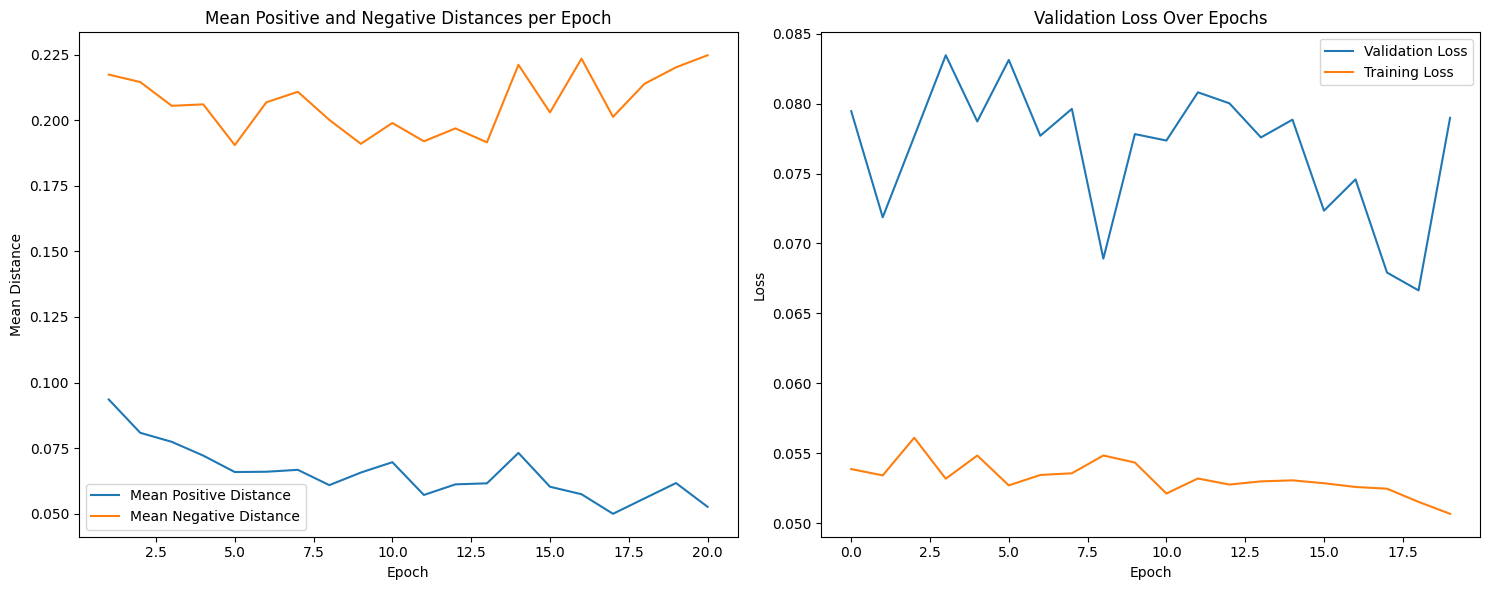

In [89]:
num_epochs = 20
train_losses = []
val_losses = []
epoch_positive_distances = []
epoch_negative_distances = []

for epoch in tqdm(range(num_epochs), desc='Training Progress'):
    train_loss, pos_distances, neg_distances = train_one_epoch(model, train_loader_step_1, optimizer, triplet_loss, device)
    train_losses.append(train_loss)

    # Calculate mean distances for each epoch
    mean_pos_distance = sum(pos_distances) / len(pos_distances)
    mean_neg_distance = sum(neg_distances) / len(neg_distances)
    epoch_positive_distances.append(mean_pos_distance)
    epoch_negative_distances.append(mean_neg_distance)

    val_loss = evaluate(model, val_loader_step_1, triplet_loss, device)
    val_losses.append(val_loss)
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}')

# After training, plot the losses and distances
plt.figure(figsize=(15, 6))

# Plot Training Loss
plt.subplot(1, 2, 1)
epochs = list(range(1, num_epochs + 1))
plt.plot(epochs, epoch_positive_distances, label='Mean Positive Distance')
plt.plot(epochs, epoch_negative_distances, label='Mean Negative Distance')
plt.xlabel('Epoch')
plt.ylabel('Mean Distance')
plt.title('Mean Positive and Negative Distances per Epoch')
plt.legend()


# Plot Validation Loss
plt.subplot(1, 2, 2)
plt.plot(val_losses, label='Validation Loss')
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Validation Loss Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()



# Save the model state
model_save_path = '/content/model_state_dict.pth'
torch.save(model.state_dict(), model_save_path)